In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from copy import deepcopy

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
input_dirs = {
    "mc": "/work/gallim/devel/CQRRelatedStudies/NormalizingFlow/samples/mc_uncorr/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/nominal",
    #"mc": "../samples/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/nominal",
    "data": "/work/gallim/devel/CQRRelatedStudies/NormalizingFlow/samples/data/DoubleEG/nominal"
    #"data": "../samples/DoubleEG/nominal"
}

input_dir = input_dirs["mc"]
files_mc = [f"{input_dir}/{f}" for f in os.listdir(input_dir)][:100]
df_mc = dd.read_parquet(files_mc).compute()
df_mc = df_mc[np.abs(df_mc.probe_eta) < 1.4442]

input_dir = input_dirs["data"]
files_data = [f"{input_dir}/{f}" for f in os.listdir(input_dir)][:100]
df_data = dd.read_parquet(files_data).compute()
df_data = df_data[np.abs(df_data.probe_eta) < 1.4442]

In [3]:
df_mc.columns

Index(['tag_chargedHadronIso', 'tag_eCorr', 'tag_energyErr', 'tag_energyRaw',
       'tag_esEffSigmaRR', 'tag_esEnergyOverRawE', 'tag_eta', 'tag_etaWidth',
       'tag_hoe', 'tag_mass', 'tag_mvaID_Fall17V1p1', 'tag_pfChargedIsoPFPV',
       'tag_pfChargedIsoWorstVtx', 'tag_pfPhoIso03', 'tag_pfRelIso03_all',
       'tag_pfRelIso03_chg', 'tag_phi', 'tag_phiWidth', 'tag_pt', 'tag_r9',
       'tag_s4', 'tag_sieie', 'tag_sieip', 'tag_trkSumPtHollowConeDR03',
       'tag_x_calo', 'tag_y_calo', 'tag_z_calo', 'tag_charge', 'tag_cutBased',
       'tag_cutBased_Fall17V1Bitmap', 'tag_electronIdx', 'tag_jetIdx',
       'tag_pdgId', 'tag_vidNestedWPBitmap', 'tag_electronVeto',
       'tag_isScEtaEB', 'tag_isScEtaEE', 'tag_mvaID_WP80', 'tag_mvaID_WP90',
       'tag_pixelSeed', 'tag_seedGain', 'tag_genPartIdx', 'tag_genPartFlav',
       'tag_cleanmask', 'tag_electronIdxG', 'tag_genPartIdxG', 'tag_jetIdxG',
       'tag_fixedGridRhoAll', 'tag_mvaID', 'probe_chargedHadronIso',
       'probe_eCorr', 'pro

In [36]:
class MaskMixin:
    """Mixin class for masking values in a numpy array"""

    def __init__(self, mask_lower_bound=None, mask_upper_bound=None):
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound

    def apply_mask(self, arr):
        mask = np.ones(arr.shape[0], dtype=bool)
        if self.mask_lower_bound is not None:
            mask = mask & (arr >= np.asarray(self.mask_lower_bound)).reshape(-1)
        if self.mask_upper_bound is not None:
            mask = mask & (arr <= np.asarray(self.mask_upper_bound)).reshape(-1)
        return mask


class Smearer(TransformerMixin, BaseEstimator, MaskMixin):
    def __init__(self, kind, mask_lower_bound=None, mask_upper_bound=None):
        if kind not in ["gaus", "uniform"]:
            raise ValueError
        self.kind = kind
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound

    def get_half_distances(self, arr):
        diffs = np.diff(arr)
        half_diffs = diffs / 2
        result = np.concatenate(
            (
                [arr[0] - half_diffs[0]],
                arr[:-1] + half_diffs,
                [arr[-1] + half_diffs[-1]],
            )
        )
        return result

    def count_occurrences(self, arr):
        unique_values = np.unique(arr).astype("int64")
        counts = np.bincount(arr.astype("int64")[:, 0])
        dct = dict(zip(unique_values, counts[unique_values]))
        # order by key
        dct = dict(sorted(dct.items()))
        return dct

    def find_closest_numbers(self, sample, numbers):
        closest_indices = np.argmin(
            np.abs(sample[:, 0] - numbers[:, np.newaxis]), axis=0
        )
        return numbers[closest_indices]

    def fit(self, X, y=None):
        self.occurrences = self.count_occurrences(X)
        self.values = np.array(list(self.occurrences.keys()))
        self.half_distances = self.get_half_distances(
            self.values
        )  # one more item wrt occurrences, values and half_widths
        self.half_widths = np.array(
            [
                np.abs(i - j)
                for i, j in zip(self.half_distances[:-1], self.half_distances[1:])
            ]
        )

        return self

    def transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        
        new_sub_arrs = []

        for idx, (number, occ) in enumerate(self.occurrences.items()):
            if self.kind == "uniform":
                smear = np.random.uniform(
                    low=self.half_distances[idx],
                    high=self.half_distances[idx + 1],
                    size=occ,
                )
            elif self.kind == "gaus":
                scale = self.half_widths[idx] / 8
                smear = np.random.normal(loc=number, scale=scale, size=occ)

            new_sub_arrs.append(smear)

        new_sub_arrs = np.concatenate(new_sub_arrs).reshape(X.shape)
        new_sub_arrs = np.sort(new_sub_arrs, axis=0)
        order = np.argsort(np.argsort(X, axis=0), axis=0).reshape(-1)
        new_sub_arrs = new_sub_arrs[order].reshape(X.shape)

        # applying smear for masked values and retaining original for others
        X_transformed = np.where(self.mask, new_sub_arrs, X)

        return X_transformed

    def inverse_transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        return np.where(
            self.mask,
            self.find_closest_numbers(X, self.values).reshape(-1, 1),
            X,
        )


class Displacer(TransformerMixin, BaseEstimator, MaskMixin):
    """Move the minimum to where_to_displace"""

    def __init__(
        self, mask_lower_bound=None, mask_upper_bound=None, where_to_displace=None
    ):
        self.mask_lower_bound = mask_lower_bound
        self.mask_upper_bound = mask_upper_bound
        self.where_to_displace = where_to_displace

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        self.minimum = np.min(X[self.mask])
        X_transformed = np.where(
            self.mask, X - self.minimum + self.where_to_displace, X
        )
        return X_transformed

    def inverse_transform(self, X, y=None):
        self.mask = self.apply_mask(X).reshape(X.shape)
        return np.where(
            self.mask, X + self.minimum - self.where_to_displace, X
        )


class IsoTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, std):
        self.std = std
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        # replace 0s with values sampled from left half of gaussian
        X[zero_indices] = np.random.normal(
            0., self.std, len(zero_indices)
        ).reshape(-1, 1)
        while any(X[zero_indices] > 0.):
            positive_indices = np.where(X[zero_indices] > 0.)[0]
            X[zero_indices[positive_indices]] = np.random.normal(
                    0., self.std, len(positive_indices)
                ).reshape(-1, 1)
        # now set back to 0 half of zero_indices randomly
        # pick half of zero_indices randomly
        #half_zero_indices = np.random.choice(
        #    zero_indices, size=len(zero_indices)//50, replace=False
        #    )
        #X[half_zero_indices] = 0.
        return X 

    def inverse_transform(self, X, y=None):
        # set all values <= 0 to 0
        X[X <= 0.] = 0.
        return X


class IsoTransformerTriangular(TransformerMixin, BaseEstimator):
    def __init__(self, shift=0.05):
        self.shift = shift
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        # replace 0s with values sampled from triangular distribution
        X[zero_indices] = np.random.triangular(
            left=0., mode=0., right=0.99*self.shift, size=len(zero_indices)
        ).reshape(-1, 1)
        # shift the rest
        X[~zero_indices] = self.shift + X[~zero_indices]
        # log transform
        X = np.log(X + 1e-3)
        return X
        
    def inverse_transform(self, X, y=None):
        X = X.copy()
        # exp transform
        X = np.exp(X) - 1e-3
        # shift the rest
        X[X > self.shift] = X[X > self.shift] - self.shift
        # set all values <= 0 to 0
        X[X <= self.shift] = 0.

        return X


def remove_outliers(arr, range, upper=True, lower=False):
    """_summary_
    For each element greater than the upper bound, replace with 
    a value sampled from a uniform distribution within the range.
    """
    if not upper and not lower:
        return arr
    if upper:
        mask = arr > range[1]
        arr[mask] = np.random.uniform(range[0], range[1], size=mask.sum())
    if lower:
        mask = arr < range[0]
        arr[mask] = np.random.uniform(range[0], range[1], size=mask.sum())
    return arr

    
class CustomLog(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        greater_than_zero = np.where(X > 0)[0]
        X[greater_than_zero] = np.log1p(X[greater_than_zero])
        self.min_value = np.min(X[greater_than_zero])
        X[greater_than_zero] -= self.min_value
        return X
    
    def inverse_transform(self, X, y=None):
        X = X.copy()
        greater_than_zero = np.where(X > 0)[0]
        X[greater_than_zero] += self.min_value
        X[greater_than_zero] = np.expm1(X[greater_than_zero])
        return X


class CustomPT(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.potr = PowerTransformer(method="box-cox")
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        greater_than_zero = np.where(X > 0)[0]
        X[greater_than_zero] = self.potr.fit_transform(X[greater_than_zero])
        self.min_value = np.min(X[greater_than_zero])
        print("Min value: ", self.min_value)
        X[greater_than_zero] -= self.min_value
        return X
    
    def inverse_transform(self, X, y=None):
        X = X.copy()
        greater_than_zero = np.where(X > 0)[0]
        X[greater_than_zero] += self.min_value
        X[greater_than_zero] = self.potr.inverse_transform(X[greater_than_zero])
        return X

# Context

## Pt

original


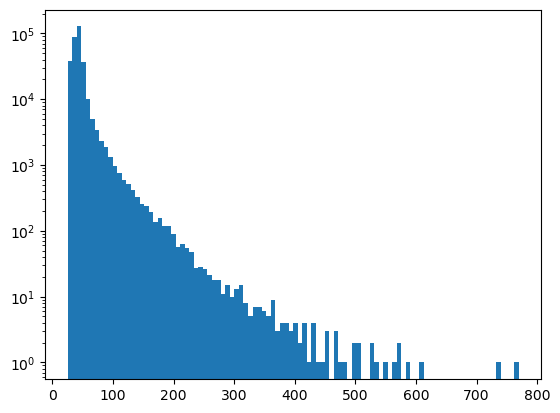

min = 25.00017547607422, max = 769.3489379882812
fraction of values <= 0: 0.0
fraction of values > 400: 0.00012512003703553097


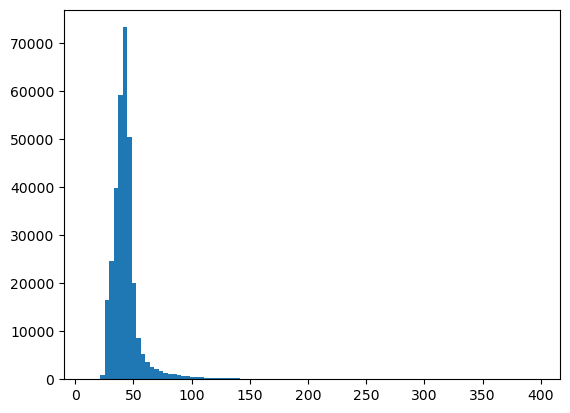

compare


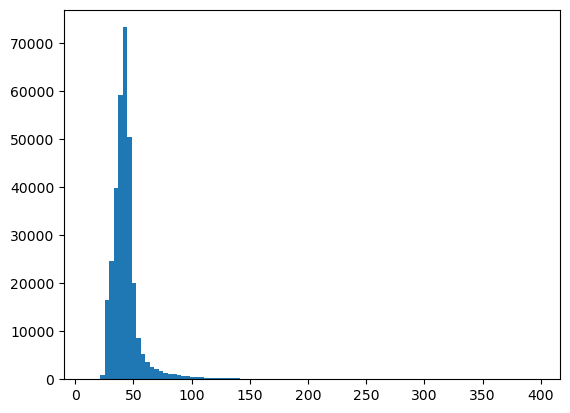

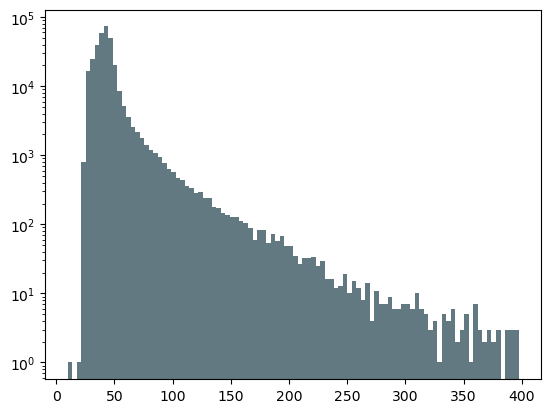

In [9]:
bins = 100
vname = "probe_pt"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 400
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values <= 0: {}".format(len(var[var <=0]) / len(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
var = remove_outliers(var, (0, out_upper))
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("sampler", IsoTransformer(0.5)),
        #("custom_log", CustomLog()),
        #("min_max", MinMaxScaler((-1, 1))),
        #("custom_pt", CustomPT()),
        #("standard", StandardScaler()),
        #("none", None),
        ("box_cox", PowerTransformer(method="box-cox")),
        #("none", None),
    ]
)

print("compare")
nvar = deepcopy(var)
new_var = pipe.fit_transform(nvar.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

## Eta

original


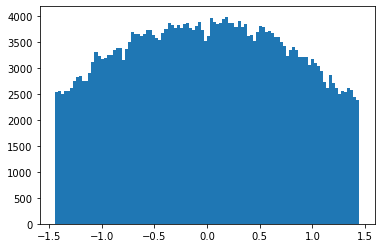

compare


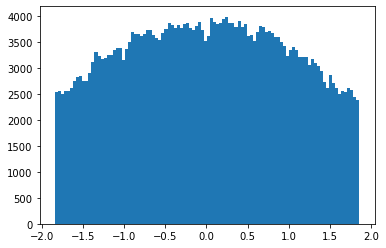

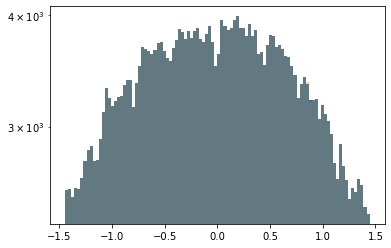

In [225]:
bins = 100
vname = "probe_eta"
var = deepcopy(df_data[vname].values)

print("original")
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        ("standard", StandardScaler()),
    ]
)

print("compare")
nvar = deepcopy(var)
new_var = pipe.fit_transform(nvar.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

## Phi

original


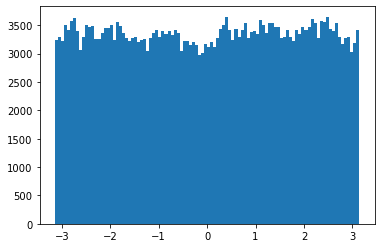

compare


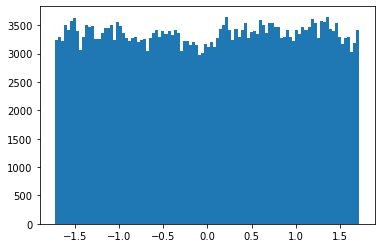

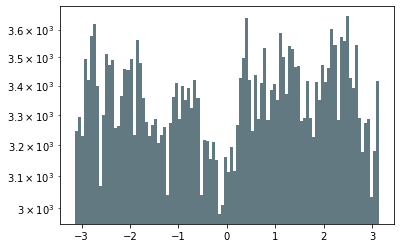

In [226]:
bins = 100
vname = "probe_phi"
var = deepcopy(df_data[vname].values)

print("original")
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        ("standard", StandardScaler()),
    ]
)

print("compare")
nvar = deepcopy(var)
new_var = pipe.fit_transform(nvar.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.show();

## Rho

original


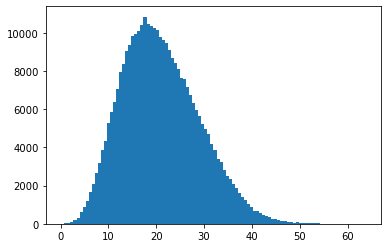

compare


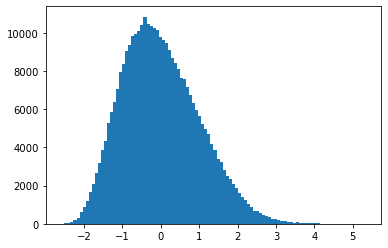

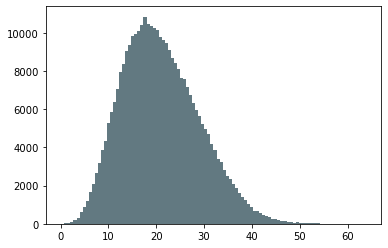

In [227]:
bins = 100
vname = "probe_fixedGridRhoAll"
var = deepcopy(df_data[vname].values)

print("original")
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        ("standard", StandardScaler()),
    ]
)

print("compare")
nvar = deepcopy(var)
new_var = pipe.fit_transform(nvar.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.show();

# Shower Shapes

## R9

original


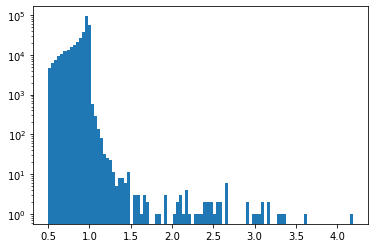

min = 0.50048828125, max = 4.1875
fraction of values <= 0: 0.0
fraction of values > 1.0: 0.01269221235713795


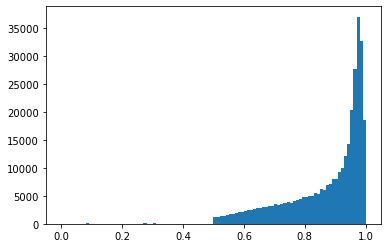

compare


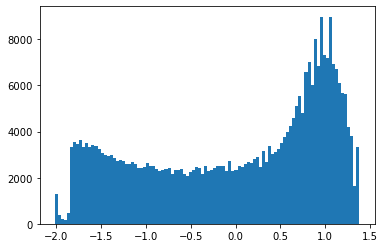

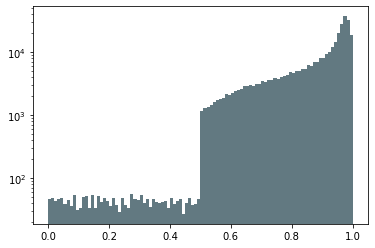

MC


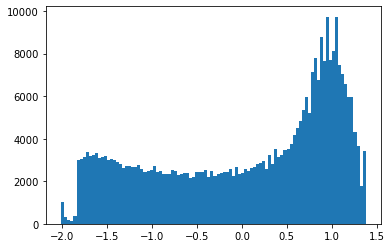

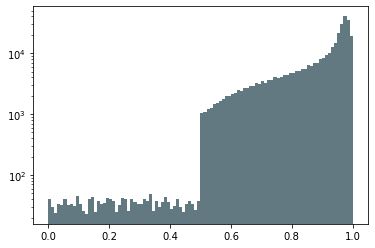

data - MC


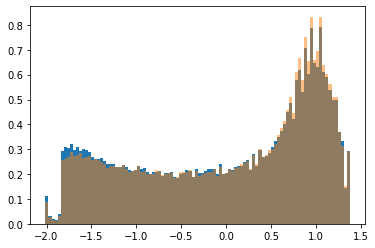

In [248]:
bins = 100
vname = "probe_r9"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 1.
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values <= 0: {}".format(len(var[var <=0]) / len(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
var = remove_outliers(var, (0, out_upper))
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        ("johnson", PowerTransformer(method="yeo-johnson")),
        ("standard", StandardScaler()),
    ]
)

print("compare")
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("MC")
var_mc = deepcopy(df_mc[vname].values)
var_mc = remove_outliers(var_mc, (0, out_upper))
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=bins);
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=bins);
plt.hist(old_var_mc, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("data - MC")
plt.hist(new_var, bins=bins, density=True);
plt.hist(new_var_mc, bins=bins, alpha=0.5, density=True);
plt.show();

## S4

original


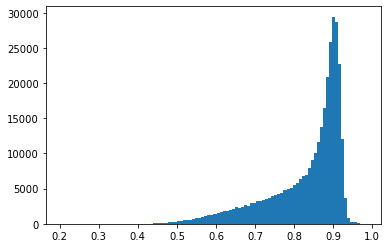

min = 0.2042236328125, max = 0.98291015625
fraction of values < 0.4: 0.00019112978608395973


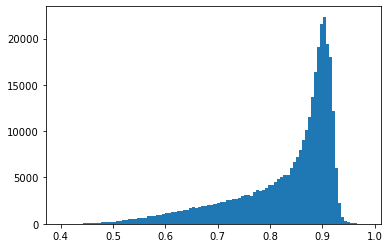

compare


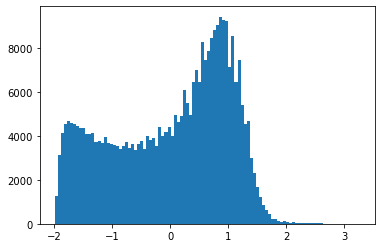

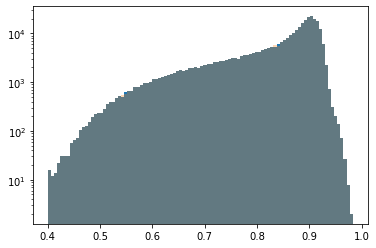

MC


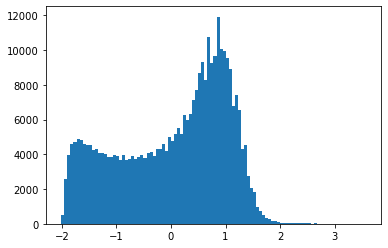

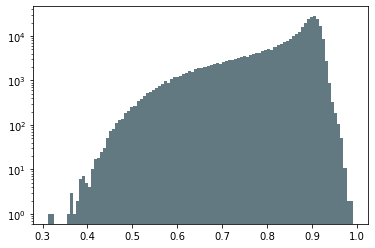

data - MC


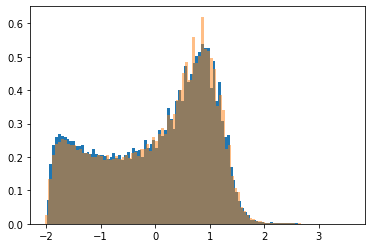

In [253]:
bins = 100
vname = "probe_s4"
var = deepcopy(df_data[vname].values)

print("original")
#plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_lower = 0.4
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values < {}: {}".format(out_lower, len(var[var < out_lower]) / len(var)))
var = remove_outliers(var, (0.4, np.max(var)), upper=False, lower=True)
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        ("johnson", PowerTransformer(method="yeo-johnson")),
        ("standard", StandardScaler()),
    ]
)

print("compare")
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("MC")
var_mc = deepcopy(df_mc[vname].values)
var_mc = remove_outliers(var_mc, (0, out_upper))
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=bins);
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=bins);
plt.hist(old_var_mc, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("data - MC")
plt.hist(new_var, bins=bins, density=True);
plt.hist(new_var_mc, bins=bins, alpha=0.5, density=True);
plt.show();

## sieie

original


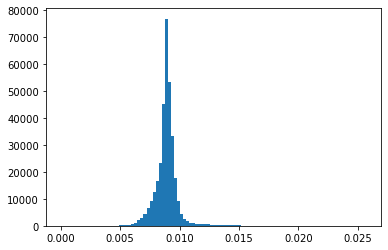

min = 5.409121513366699e-05, max = 0.0256500244140625
fraction of values > 0.016: 0.0026907490197132455
fraction of values < 0.005: 0.0012453300124533001


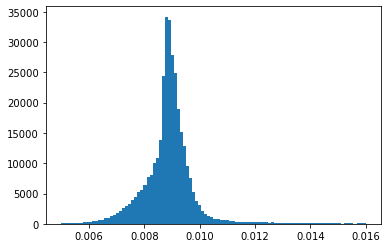

compare


/Users/massimiliano/opt/anaconda3/envs/stats-studies/lib/python3.9/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


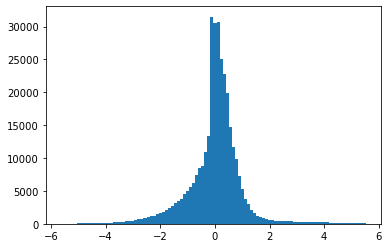

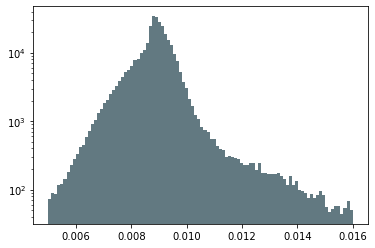

MC


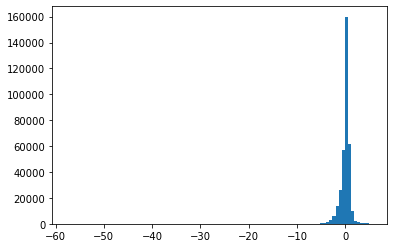

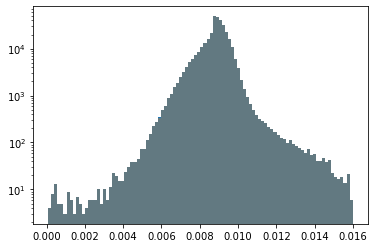

data - MC


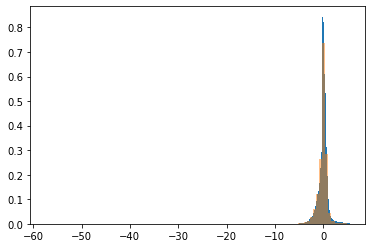

In [283]:
bins = 100
vname = "probe_sieie"
var = deepcopy(df_data[vname].values)

print("original")
#plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 0.016
out_lower = 0.005
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
print("fraction of values < {}: {}".format(out_lower, len(var[var < out_lower]) / len(var)))
var = remove_outliers(var, (out_lower, out_upper), upper=True, lower=True)
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("johnson", PowerTransformer(method="yeo-johnson")),
        #("minmax", MinMaxScaler((0, 1))),
        #("log", FunctionTransformer(np.log1p, np.expm1)),
        #("log", FunctionTransformer(lambda x: np.log(x + 1e-1), lambda x: (np.exp(x) - 1e-1))),
        #("sqrt", FunctionTransformer(np.sqrt, np.square)),
        ("box-cox", PowerTransformer(method="box-cox")),
        #("arcatan", FunctionTransformer(lambda x: np.arctan(x - 1.25), lambda x: np.tan(x) + 1.25)),
        ("standard", StandardScaler()),
    ]
)

print("compare")
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("MC")
var_mc = deepcopy(df_mc[vname].values)
var_mc = remove_outliers(var_mc, (0, out_upper))
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=bins);
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=bins);
plt.hist(old_var_mc, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("data - MC")
plt.hist(new_var, bins=bins, density=True);
plt.hist(new_var_mc, bins=bins, alpha=0.5, density=True);
plt.show();

## sieip

original


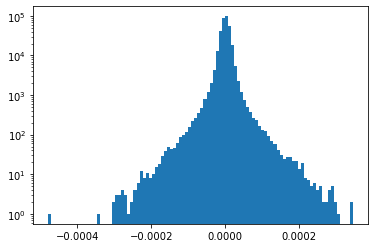

min = -0.00047898292541503906, max = 0.00034427642822265625
fraction of values > 0.0002: 0.00023891223260494966
fraction of values < -0.0002: 0.0002030753977142072


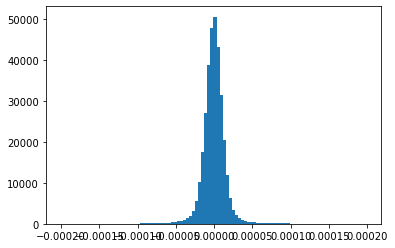

compare


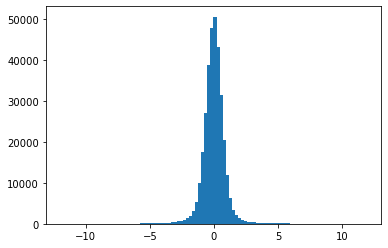

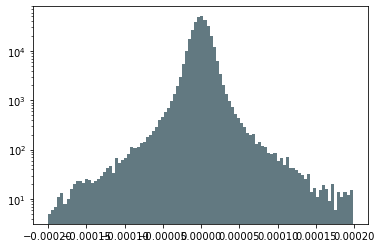

MC


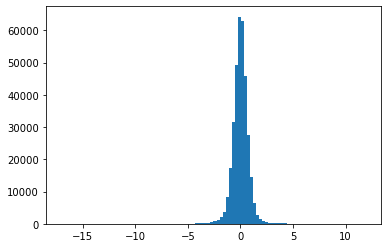

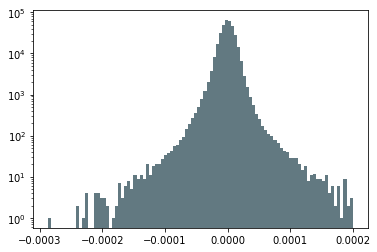

data - MC


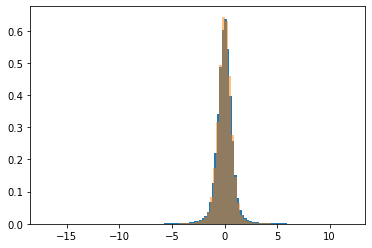

In [296]:
bins = 100
vname = "probe_sieip"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 0.0002
out_lower = -0.0002
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
print("fraction of values < {}: {}".format(out_lower, len(var[var < out_lower]) / len(var)))
var = remove_outliers(var, (out_lower, out_upper), upper=True, lower=True)
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("johnson", PowerTransformer(method="yeo-johnson")),
        #("minmax", MinMaxScaler((0, 1))),
        ("log", FunctionTransformer(np.log1p, np.expm1)),
        #("log", FunctionTransformer(lambda x: np.log(x + 1e-1), lambda x: (np.exp(x) - 1e-1))),
        #("sqrt", FunctionTransformer(np.sqrt, np.square)),
        #("box-cox", PowerTransformer(method="box-cox")),
        #("arcatan", FunctionTransformer(lambda x: np.arctan(x - 1.25), lambda x: np.tan(x) + 1.25)),
        ("standard", StandardScaler()),
    ]
)

print("compare")
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("MC")
var_mc = deepcopy(df_mc[vname].values)
var_mc = remove_outliers(var_mc, (0, out_upper))
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=bins);
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=bins);
plt.hist(old_var_mc, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("data - MC")
plt.hist(new_var, bins=bins, density=True);
plt.hist(new_var_mc, bins=bins, alpha=0.5, density=True);
plt.show();

## EtaWidth

original


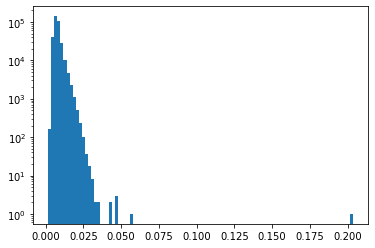

min = 0.0017385482788085938, max = 0.203369140625
fraction of values > 0.03: 5.6741655243675546e-05


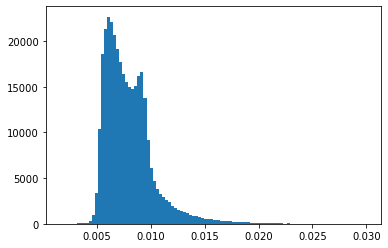

compare


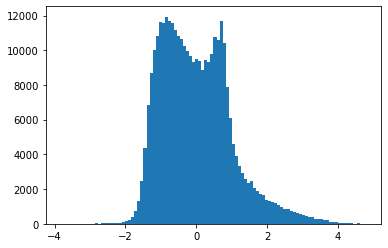

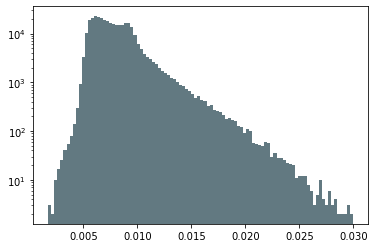

MC


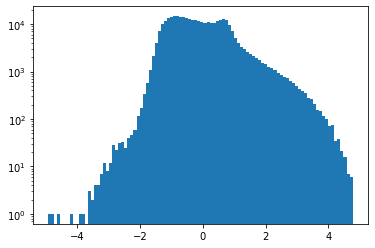

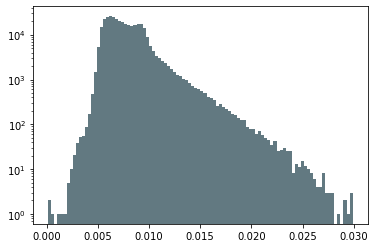

data - MC


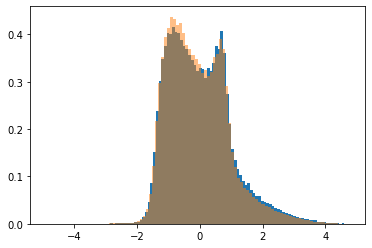

In [303]:
bins = 100
vname = "probe_etaWidth"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 0.03
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
var = remove_outliers(var, (np.min(var), out_upper), upper=True, lower=False)
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("johnson", PowerTransformer(method="yeo-johnson")),
        #("minmax", MinMaxScaler((0, 1))),
        #("log", FunctionTransformer(np.log1p, np.expm1)),
        #("log", FunctionTransformer(lambda x: np.log(x + 1e-1), lambda x: (np.exp(x) - 1e-1))),
        #("sqrt", FunctionTransformer(np.sqrt, np.square)),
        #("box-cox", PowerTransformer(method="box-cox")),
        #("arcatan", FunctionTransformer(lambda x: np.arctan(x - 1.25), lambda x: np.tan(x) + 1.25)),
        (
            "arctan_trans",
            FunctionTransformer(
                lambda x: np.arctan(x * 100 - 0.15),
                inverse_func=lambda x: (np.tan(x) + 0.15) / 100,
            ),
        ),
        ("standard", StandardScaler()),
    ]
)

print("compare")
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("MC")
var_mc = deepcopy(df_mc[vname].values)
var_mc = remove_outliers(var_mc, (0, out_upper))
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=bins);
plt.yscale('log')
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=bins);
plt.hist(old_var_mc, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("data - MC")
plt.hist(new_var, bins=bins, density=True);
plt.hist(new_var_mc, bins=bins, alpha=0.5, density=True);
plt.show();

## PhiWidth

original


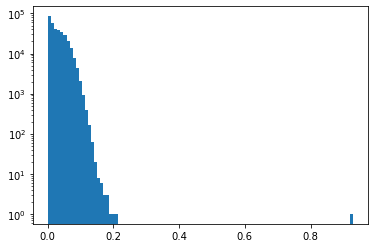

min = 0.0021266937255859375, max = 0.927734375
fraction of values > 0.21: 2.986402907561871e-06


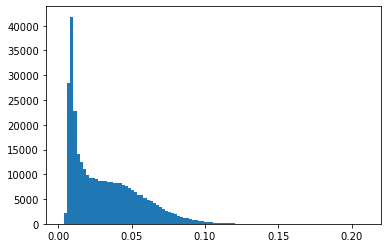

compare


/Users/massimiliano/opt/anaconda3/envs/stats-studies/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:167: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(


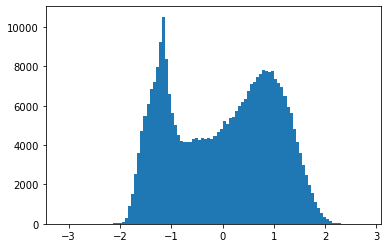

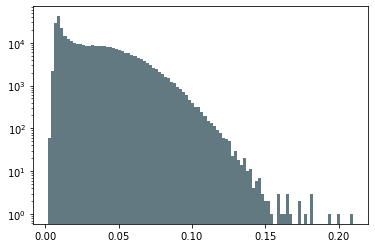

MC


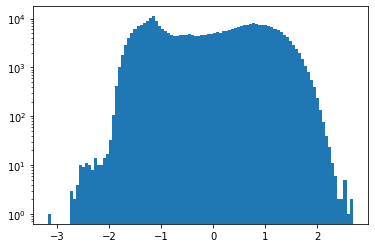

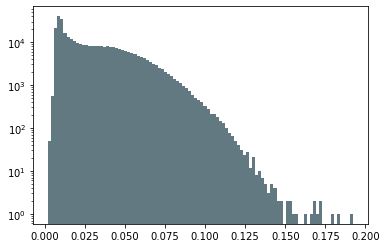

data - MC


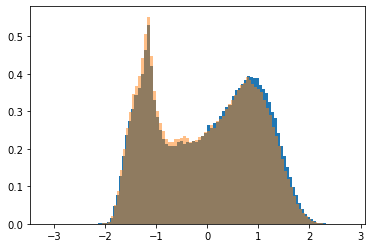

In [310]:
bins = 100
vname = "probe_phiWidth"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 0.21
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
var = remove_outliers(var, (np.min(var), out_upper), upper=True, lower=False)
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("johnson", PowerTransformer(method="yeo-johnson")),
        #("minmax", MinMaxScaler((0, 1))),
        ("log", FunctionTransformer(np.log, np.exp)),
        #("log", FunctionTransformer(lambda x: np.log(x + 1e-1), lambda x: (np.exp(x) - 1e-1))),
        #("sqrt", FunctionTransformer(np.sqrt, np.square)),
        #("box-cox", PowerTransformer(method="box-cox")),
        #("arcatan", FunctionTransformer(lambda x: np.arctan(x - 1.25), lambda x: np.tan(x) + 1.25)),
        #(
        #    "arctan_trans",
        #    FunctionTransformer(
        #        lambda x: np.arctan(x * 100 - 0.15),
        #        inverse_func=lambda x: (np.tan(x) + 0.15) / 100,
        #    ),
        #),
        ("standard", StandardScaler()),
    ]
)

print("compare")
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("MC")
var_mc = deepcopy(df_mc[vname].values)
var_mc = remove_outliers(var_mc, (0, out_upper))
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=bins);
plt.yscale('log')
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=bins);
plt.hist(old_var_mc, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

print("data - MC")
plt.hist(new_var, bins=bins, density=True);
plt.hist(new_var_mc, bins=bins, alpha=0.5, density=True);
plt.show();

# Isolations

0.0 279.97226
0.14194840244928755
0.002843959488087292
0.005642133 9.997946
-5.177493 2.3023796


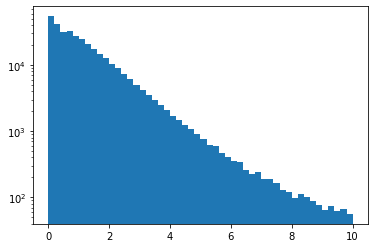

In [177]:
var = deepcopy(df_mc['probe_pfPhoIso03'].values)
print(np.min(var), np.max(var))
print(len(var[var <=0]) / len(var))
print(len(var[var > 10]) / len(var))
var = remove_outliers(var, (0, 10))
#var = var[var > 10]
plt.yscale('log')
plt.hist(var, bins=50);

v = var[var > 0]
print(np.min(v), np.max(v))
v = np.log(v)
print(np.min(v), np.max(v))

0.0 39.06622
0.6202727502677452
0.0006269811798009806


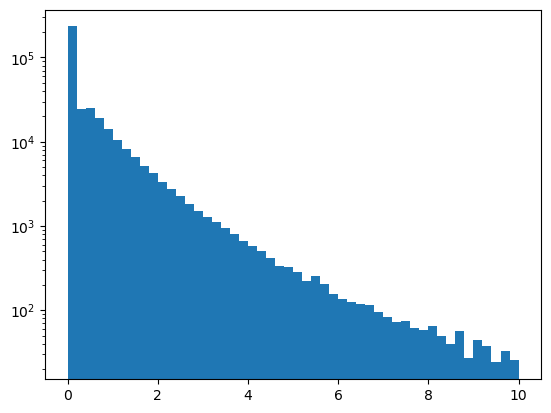

-0.7039859
-0.6489588


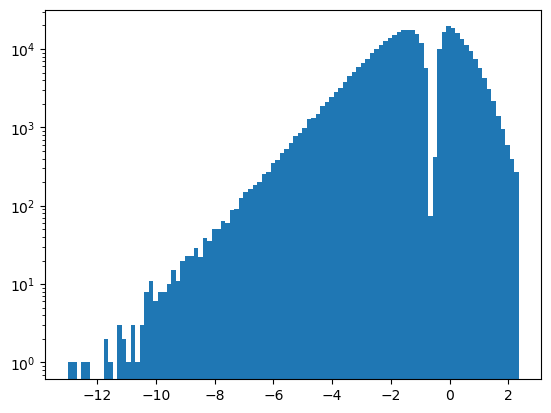

In [108]:
var = deepcopy(df_mc['probe_pfChargedIsoPFPV'].values)
print(np.min(var), np.max(var))
print(len(var[var <=0]) / len(var))
print(len(var[var > 10]) / len(var))
var = remove_outliers(var, (0, 10))
plt.hist(var, bins=50);
plt.yscale('log')
plt.show();
var_minus = var[var <= 0]
var_plus = var[var > 0]
# triangular distribution with elements like var_minus
shift = 0.5
#var_minus = np.random.triangular(
#    left=0., mode=0., right=0.99*shift, size=len(var_minus)
#)
##var_minus = np.log(var_minus + 1e-3)
#print(np.max(var_minus))
#var_plus += shift
##var_plus = np.log(var_plus + 1e-3)
#print(np.min(var_plus))
#var = np.concatenate((var_minus, var_plus))
#var = np.log(var + 1e-3)
where_zero = np.where(var <= 0)[0]
where_nonzero = np.where(var > 0)[0]
var[where_zero] = np.random.triangular(
    left=0., mode=0., right=0.99*shift, size=len(where_zero)
)
var[where_nonzero] += shift
var = np.log(var)
print(np.max(var[where_zero]))
print(np.min(var[where_nonzero]))
plt.hist(var, bins=100);
plt.yscale('log')
plt.show();

0.0 258.67712
0.019907716416611047
0.005104617081168925


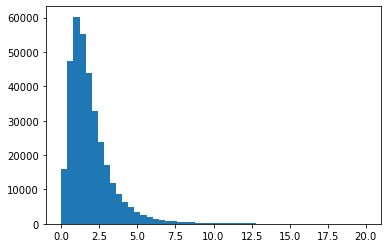

In [49]:
var = deepcopy(df_mc['probe_pfChargedIsoWorstVtx'].values)
print(np.min(var), np.max(var))
print(len(var[var <=0]) / len(var))
print(len(var[var > 20]) / len(var))
var = remove_outliers(var, (0, 20))
#plt.yscale('log')
plt.hist(var, bins=50);

# Isolations - Transformations

## PhotonIso

original


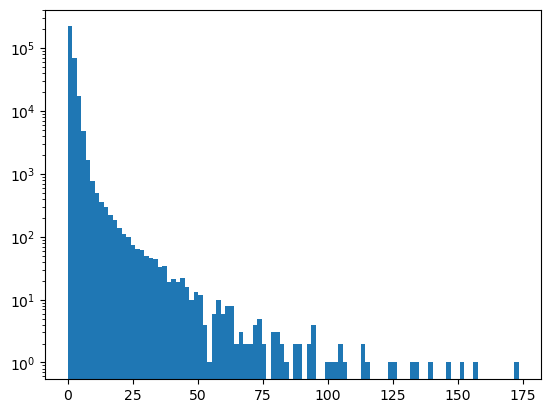

min = 0.0, max = 173.33009338378906
fraction of values <= 0: 0.11761596281432499
fraction of values > 10: 0.008467498506379558


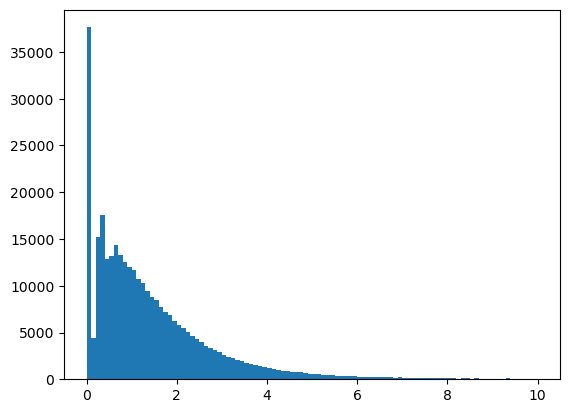

compare


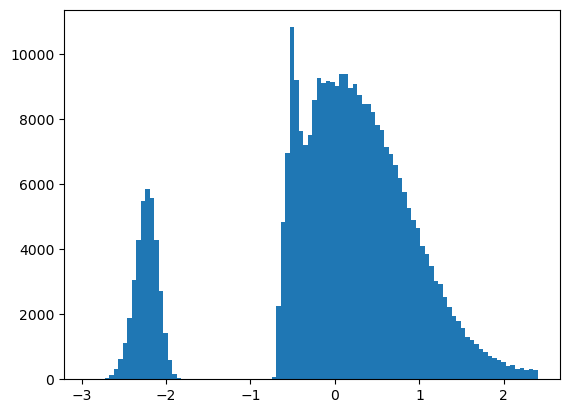

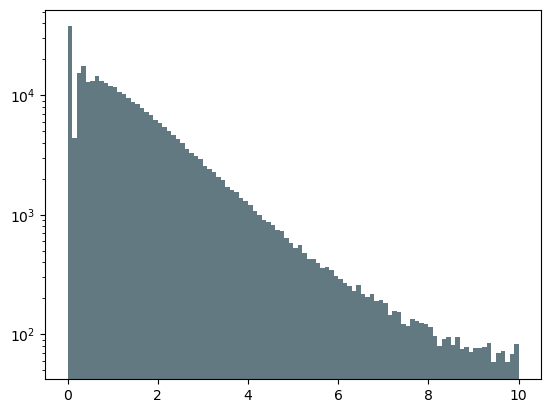

In [113]:
bins = 100
vname = "probe_pfPhoIso03"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 10
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values <= 0: {}".format(len(var[var <=0]) / len(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
var = remove_outliers(var, (0, out_upper))
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("sampler", IsoTransformer(0.5)),
        #("custom_log", CustomLog()),
        #("standard", StandardScaler()),
        ("sampler", IsoTransformerLNorm()),
        ("standard", StandardScaler()),
    ]
)

print("compare")
nvar = deepcopy(var)
new_var = pipe.fit_transform(nvar.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();

## ChargedIso

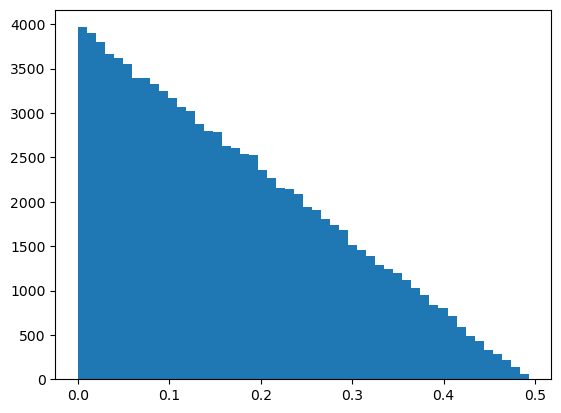

In [79]:
triangular = np.random.triangular(left=0., mode=0., right=0.99*0.5, size=100000)
#triangular = np.log(triangular)
plt.hist(triangular, bins=50);

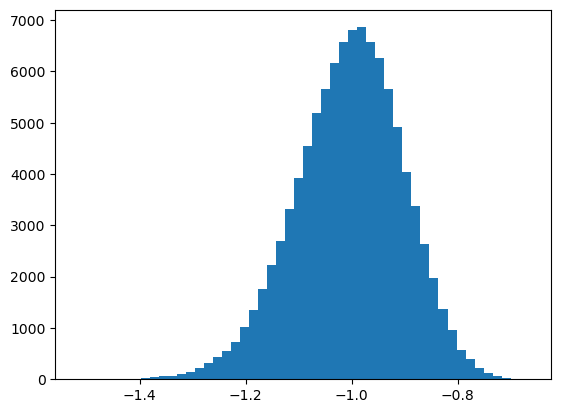

In [104]:
lnorm = -np.random.lognormal(mean=0.0001, sigma=0.1, size=100000)
plt.hist(lnorm, bins=50);

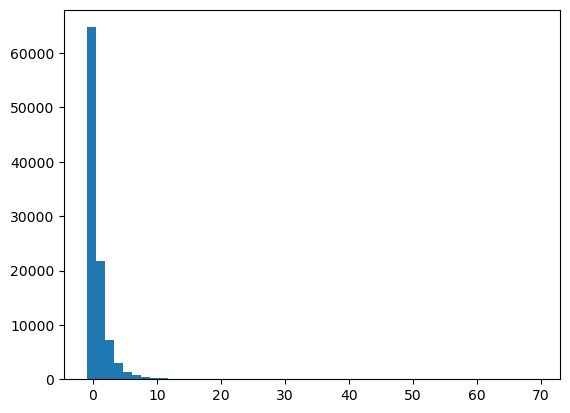

In [84]:
from scipy.stats import lognorm
sample = lognorm.rvs(0.954, -1, 1, size=100000)
plt.hist(sample, bins=50);

original


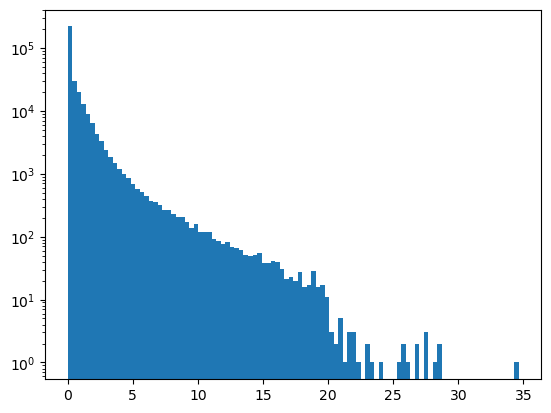

min = 0.0, max = 34.62345504760742
0.055108093
fraction of values <= 0: 0.6367139724673359
fraction of values > 10: 0.004813993424942054


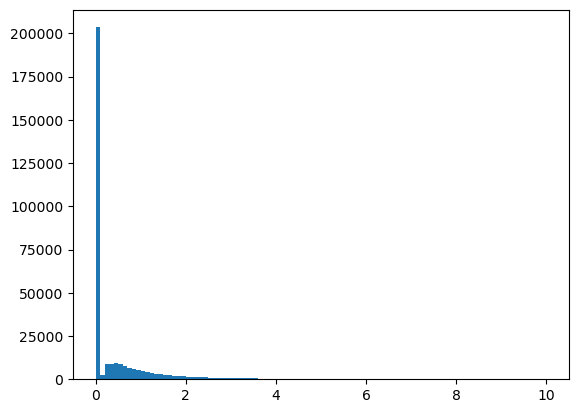

compare


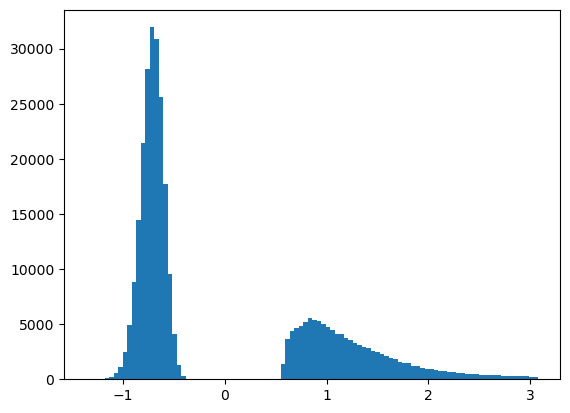

0s in var: 203553, 0s in old_var 203553


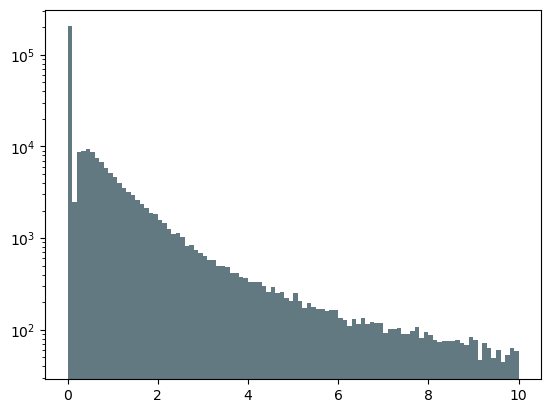

MC


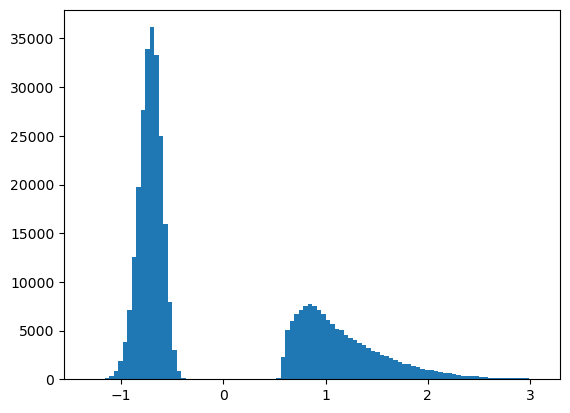

0s in var: 230507, 0s in old_var 230507


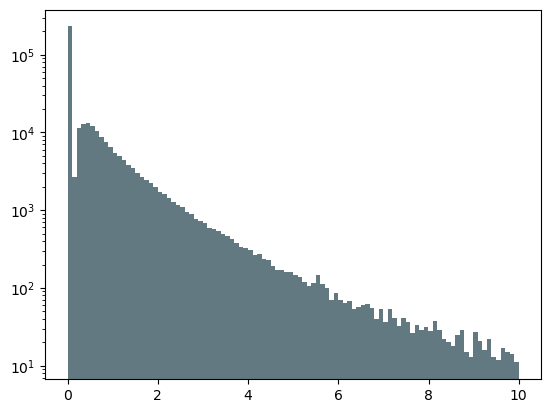

data - MC


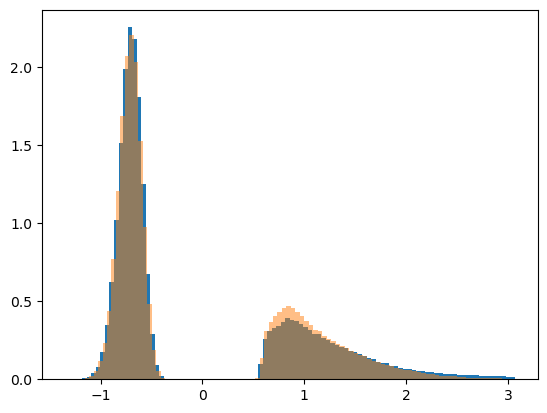

In [112]:
class IsoTransformerLNorm(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # replace 0s with values sampled from triangular distribution
        X[zero_indices] = -np.random.lognormal(mean=0.0001, sigma=0.1, size=len(zero_indices)).reshape(-1, 1)
        # shift the rest
        X[nonzero_indices] = np.log1p(X[nonzero_indices])
        return X
        
    def inverse_transform(self, X, y=None):
        X = X.copy()
        zero_indices = np.where(X <= 0)[0]
        nonzero_indices = np.where(X > 0)[0]
        # expm1 the rest
        X[nonzero_indices] = np.expm1(X[nonzero_indices])
        # replace values less than 0 with 0
        X[zero_indices] = 0.
        return X

bins = 100
vname = "probe_pfChargedIsoPFPV"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 10
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print(np.min(var[var > 0]))
print("fraction of values <= 0: {}".format(len(var[var <=0]) / len(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
var = remove_outliers(var, (0, out_upper))
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("sampler", IsoTransformer(1.5)),
        #("custom_log", CustomLog()),
        #("custom_pt", CustomPT()),
        #("min_max", MinMaxScaler((-1, 1))),
        ("sampler", IsoTransformerLNorm()),
        ("standard", StandardScaler()),
    ]
)

print("compare")
new_var = pipe.fit_transform(var.reshape(-1, 1))
plt.hist(new_var, bins=bins);
#plt.yscale('log')
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
print("0s in var: {}, 0s in old_var {}".format(len(var[var == 0]), len(old_var[old_var == 0])))
plt.yscale('log')
plt.show();

print("MC")
var_mc = deepcopy(df_mc[vname].values)
var_mc = remove_outliers(var_mc, (0, out_upper))
new_var_mc = pipe.transform(var_mc.reshape(-1, 1))
plt.hist(new_var_mc, bins=bins);
plt.show();
old_var_mc = pipe.inverse_transform(new_var_mc)
plt.hist(var_mc, bins=bins);
plt.hist(old_var_mc, bins=bins, alpha=0.3);
print("0s in var: {}, 0s in old_var {}".format(len(var_mc[var_mc == 0]), len(old_var_mc[old_var_mc == 0])))
plt.yscale('log')
plt.show();

print("data - MC")
plt.hist(new_var, bins=bins, density=True);
plt.hist(new_var_mc, bins=bins, alpha=0.5, density=True);
plt.show();

## ChargedIso Worst

original


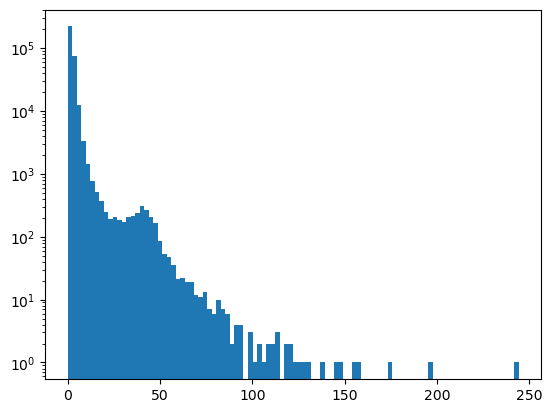

min = 0.0, max = 244.0796356201172
fraction of values <= 0: 0.013597420024836328
fraction of values > 100: 8.44560249989834e-05


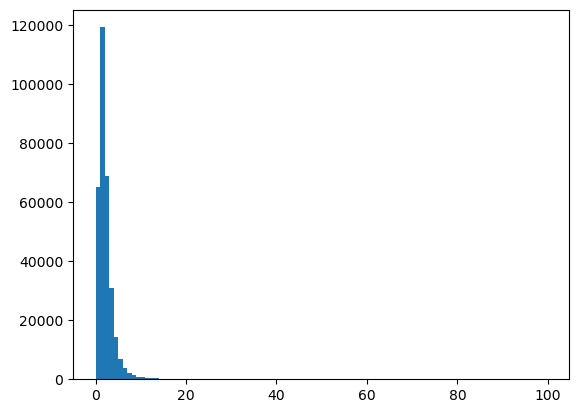

compare


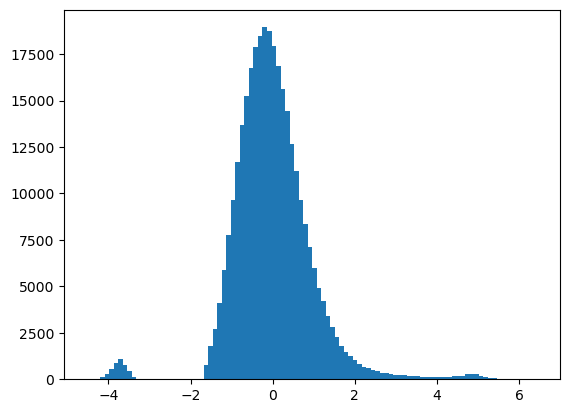

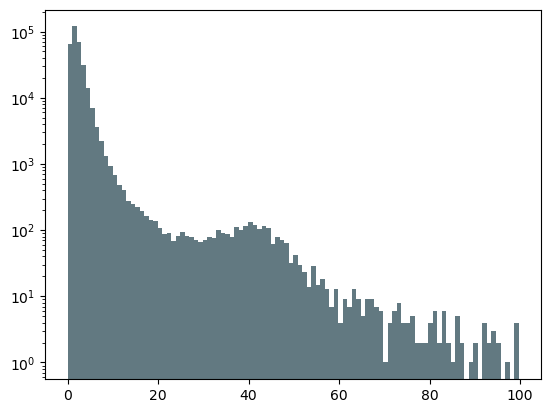

In [114]:
bins = 100
vname = "probe_pfChargedIsoWorstVtx"
var = deepcopy(df_data[vname].values)

print("original")
plt.yscale('log')
plt.hist(var, bins=bins);
plt.show();

out_upper = 100 
print("min = {}, max = {}".format(np.min(var), np.max(var)))
print("fraction of values <= 0: {}".format(len(var[var <=0]) / len(var)))
print("fraction of values > {}: {}".format(out_upper, len(var[var > out_upper]) / len(var)))
var = remove_outliers(var, (0, out_upper))
plt.hist(var, bins=bins);
plt.show();

pipe = Pipeline(
    [
        #("sampler", IsoTransformer(0.1)),
        #("custom_log", CustomLog()),
        #("custom_pt", CustomPT()),
        #("standard", StandardScaler()),
        ("sampler", IsoTransformerLNorm()),
        ("standard", StandardScaler()),
    ]
)

print("compare")
nvar = deepcopy(var)
new_var = pipe.fit_transform(nvar.reshape(-1, 1))
plt.hist(new_var, bins=bins);
plt.show();
old_var = pipe.inverse_transform(new_var)
plt.hist(var, bins=bins);
plt.hist(old_var, bins=bins, alpha=0.3);
plt.yscale('log')
plt.show();